###  필요 라이브러리 Import

In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 장치:", device)

DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

MODEL_NAME   = "bert-base-uncased"

MAX_LENGTH   = 256
BATCH_SIZE   = 16
SUBSET_FRAC  = None

EPOCHS       = 3
LR           = 2e-5
WARMUP_RATIO = 0.1


C:\Users\sy030\anaconda3\envs\synopsify\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


사용 장치: cuda


### 데이터 로드 및 장르 라벨 인코딩


In [2]:
train_path          = os.path.join(DATA_DIR, "train_data.txt")
test_solution_path  = os.path.join(DATA_DIR, "test_data_solution.txt")

# train_data: Index ::: Title ::: Genre ::: Content
train_df_full = pd.read_table(
    train_path,
    sep=":::",
    engine="python",
    names=["Index", "Title", "Genre", "Content"]
)

# test_data_solution: 정답 포함 (kaggle에서 따로 준 test 세트)
test_df = pd.read_table(
    test_solution_path,
    sep=":::",
    engine="python",
    names=["Index", "Title", "Genre", "Content"]
)

print("원본 train 크기:", train_df_full.shape)
print("test(solution) 크기:", test_df.shape)

# 공백 제거
train_df_full["Genre"] = train_df_full["Genre"].str.strip()
test_df["Genre"]       = test_df["Genre"].str.strip()

# 라벨 인코딩
label_list = sorted(train_df_full["Genre"].unique())
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for label, idx in label2id.items()}
NUM_LABELS = len(label_list)

print("장르 개수:", NUM_LABELS)
print("라벨 예시:", list(label2id.items())[:10])

train_df_full["label"] = train_df_full["Genre"].map(label2id)
test_df["label"]       = test_df["Genre"].map(label2id)

# test 에 train에 없는 장르가 있으면 제거
test_df = test_df.dropna(subset=["label"]).reset_index(drop=True)
test_df["label"] = test_df["label"].astype(int)

if SUBSET_FRAC is not None and SUBSET_FRAC < 1.0:
    subset_df, _ = train_test_split(
        train_df_full,
        train_size=SUBSET_FRAC,
        random_state=SEED,
        stratify=train_df_full["label"]
    )
    print(f"\n원본 train 샘플 수 : {len(train_df_full)}")
    print(f"서브셋 ({SUBSET_FRAC*100:.0f}%) 샘플 수: {len(subset_df)}")
else:
    # SUBSET_FRAC 이 None, 1.0, 1 이상이면 전체 train 사용
    subset_df = train_df_full.copy()
    print(f"\n서브셋 사용 안 함 → 전체 train 사용 (샘플 수: {len(subset_df)})")

# train / val 분리
train_df, val_df = train_test_split(
    subset_df,
    test_size=0.2,
    random_state=SEED,
    stratify=subset_df["label"]
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print("\n최종 분할 결과")
print("train:", train_df.shape)
print("val  :", val_df.shape)
print("test :", test_df.shape)


원본 train 크기: (54214, 4)
test(solution) 크기: (54200, 4)
장르 개수: 27
라벨 예시: [('action', 0), ('adult', 1), ('adventure', 2), ('animation', 3), ('biography', 4), ('comedy', 5), ('crime', 6), ('documentary', 7), ('drama', 8), ('family', 9)]

서브셋 사용 안 함 → 전체 train 사용 (샘플 수: 54214)

최종 분할 결과
train: (48792, 5)
val  : (5422, 5)
test : (54200, 5)


### Dataset / DataLoader / 토크나이저 & 모델

In [3]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class MovieGenreDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.texts = (
            df["Title"].fillna("") + " " + df["Content"].fillna("")
        ).tolist()
        self.labels = df["label"].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

train_dataset = MovieGenreDataset(train_df, tokenizer, MAX_LENGTH)
val_dataset   = MovieGenreDataset(val_df,   tokenizer, MAX_LENGTH)
test_dataset  = MovieGenreDataset(test_df,  tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print("배치 개수 - train:", len(train_loader),
      "/ val:", len(val_loader),
      "/ test:", len(test_loader))

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id
)
model.to(device)

print("모델 로드 완료:", MODEL_NAME)

배치 개수 - train: 3050 / val: 339 / test: 3388


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델 로드 완료: bert-base-uncased


### Optimizer / Scheduler / train & eval 함수

In [4]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR
)

total_steps  = len(train_loader) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

def train_one_epoch(epoch):
    model.train()
    total_loss = 0.0
    n_seen = 0

    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Train Epoch {epoch}", leave=False)

    for step, batch in enumerate(progress_bar, start=1):
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels   # 내부에서 CrossEntropyLoss 사용
        )
        loss   = outputs.loss
        logits = outputs.logits

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        bs = labels.size(0)
        total_loss += loss.item() * bs
        n_seen     += bs

        preds = torch.argmax(logits, dim=1)   # single-label, top-1
        all_preds.append(preds.detach().cpu())
        all_labels.append(labels.detach().cpu())

        avg_loss_so_far = total_loss / n_seen
        progress_bar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "avg_loss": f"{avg_loss_so_far:.4f}"
        })

    all_preds  = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    avg_loss = total_loss / len(train_dataset)
    acc      = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro")

    print(f"[Train] Epoch {epoch} | loss={avg_loss:.4f} | acc={acc:.4f} | F1_macro={f1_macro:.4f}")
    return avg_loss, acc, f1_macro


def eval_one_epoch(epoch):
    model.eval()
    total_loss = 0.0
    n_seen = 0

    all_preds = []
    all_labels = []

    progress_bar = tqdm(val_loader, desc=f"Eval  Epoch {epoch}", leave=False)

    with torch.no_grad():
        for step, batch in enumerate(progress_bar, start=1):
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss   = outputs.loss
            logits = outputs.logits

            bs = labels.size(0)
            total_loss += loss.item() * bs
            n_seen     += bs

            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.detach().cpu())
            all_labels.append(labels.detach().cpu())

            avg_loss_so_far = total_loss / n_seen
            progress_bar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "avg_loss": f"{avg_loss_so_far:.4f}"
            })

    all_preds  = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    avg_loss = total_loss / len(val_dataset)
    acc      = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro")

    print(f"[Val]   Epoch {epoch} | loss={avg_loss:.4f} | acc={acc:.4f} | F1_macro={f1_macro:.4f}")
    return avg_loss, acc, f1_macro


### 학습 루프 + best 모델 저장 + history 기록

In [5]:
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "train_f1_macro": [],
    "val_loss": [],
    "val_acc": [],
    "val_f1_macro": [],
}

best_val_f1    = 0.0
best_state_dict = None

for epoch in range(1, EPOCHS + 1):
    print("=" * 60)
    print(f"Epoch {epoch}/{EPOCHS}")

    train_loss, train_acc, train_f1_macro = train_one_epoch(epoch)
    val_loss,   val_acc,   val_f1_macro   = eval_one_epoch(epoch)

    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["train_f1_macro"].append(train_f1_macro)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_f1_macro"].append(val_f1_macro)

    if val_f1_macro > best_val_f1:
        best_val_f1 = val_f1_macro
        best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        print(f"🔥 New best model! val F1_macro = {best_val_f1:.4f}")

# best 모델 로드
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    model.to(device)
    print(f"\n✅ Best model loaded (val F1_macro = {best_val_f1:.4f})")

Epoch 1/3


[Train] Epoch 1 | loss=1.4940 | acc=0.5784 | F1_macro=0.2736


[Val]   Epoch 1 | loss=1.0836 | acc=0.6772 | F1_macro=0.4030
🔥 New best model! val F1_macro = 0.4030
Epoch 2/3


[Train] Epoch 2 | loss=0.8917 | acc=0.7329 | F1_macro=0.4691


[Val]   Epoch 2 | loss=1.0290 | acc=0.6890 | F1_macro=0.4460
🔥 New best model! val F1_macro = 0.4460
Epoch 3/3


[Train] Epoch 3 | loss=0.6309 | acc=0.8159 | F1_macro=0.6038


[Val]   Epoch 3 | loss=1.0800 | acc=0.6918 | F1_macro=0.4730
🔥 New best model! val F1_macro = 0.4730

✅ Best model loaded (val F1_macro = 0.4730)


### Epoch별 Loss / F1 그래프

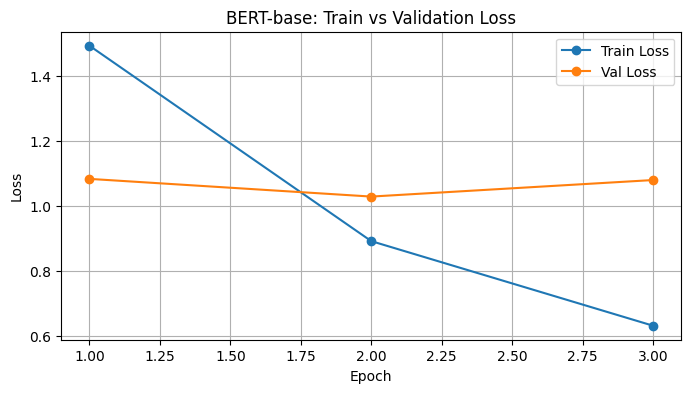

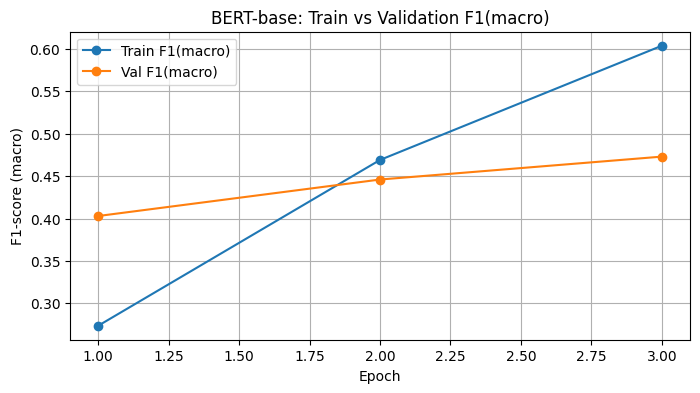

In [6]:
epochs = history["epoch"]

plt.figure(figsize=(8,4))
plt.plot(epochs, history["train_loss"], marker="o", label="Train Loss")
plt.plot(epochs, history["val_loss"],   marker="o", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BERT-base: Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, history["train_f1_macro"], marker="o", label="Train F1(macro)")
plt.plot(epochs, history["val_f1_macro"],   marker="o", label="Val F1(macro)")
plt.xlabel("Epoch")
plt.ylabel("F1-score (macro)")
plt.title("BERT-base: Train vs Validation F1(macro)")
plt.legend()
plt.grid(True)
plt.show()

### Test 데이터(test_data_solution.txt) 최종 평가

In [7]:
def evaluate_on_loader(loader):
    model.eval()
    total_loss = 0.0
    n_seen = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Test", leave=False):
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss   = outputs.loss
            logits = outputs.logits

            bs = labels.size(0)
            total_loss += loss.item() * bs
            n_seen     += bs

            preds = torch.argmax(logits, dim=1)   # top-1 (argmax)
            all_preds.append(preds.detach().cpu())
            all_labels.append(labels.detach().cpu())

    all_preds  = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    avg_loss = total_loss / len(loader.dataset)
    acc      = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro")
    f1_micro = f1_score(all_labels, all_preds, average="micro")

    return avg_loss, acc, f1_macro, f1_micro

test_loss, test_acc, test_f1_macro, test_f1_micro = evaluate_on_loader(test_loader)

print("\n📊 Test 결과 (test_data_solution.txt 기준)")
print(f"loss      : {test_loss:.4f}")
print(f"accuracy  : {test_acc:.4f}")
print(f"F1_macro  : {test_f1_macro:.4f}")
print(f"F1_micro  : {test_f1_micro:.4f}")


📊 Test 결과 (test_data_solution.txt 기준)
loss      : 1.0699
accuracy  : 0.6947
F1_macro  : 0.4838
F1_micro  : 0.6947


### 베스트 모델 저장

In [8]:
SAVE_DIR = "model/bert"
os.makedirs(SAVE_DIR, exist_ok=True)

try:
    if "best_state_dict" in globals() and best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        print(f"✅ best_state_dict 로드 완료 (best_epoch = {best_epoch})")
except NameError:
    print("⚠️ best_state_dict가 없어 현재 model 그대로 저장합니다.")

model.to("cpu")

if "label2id" in globals():
    model.config.label2id = {str(k): int(v) for k, v in label2id.items()}
if "id2label" in globals():
    model.config.id2label = {int(k): str(v) for k, v in id2label.items()}

model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

meta = {
    "best_epoch": best_epoch if "best_epoch" in globals() else None,
    "history": history if "history" in globals() else None,
}
torch.save(meta, os.path.join(SAVE_DIR, "train_meta.pt"))

print("\n✅ BERT 모델 저장 완료")
print("   - 모델 / config / 가중치:", SAVE_DIR)
print("   - 학습 메타 정보       :", os.path.join(SAVE_DIR, 'train_meta.pt'))

⚠️ best_state_dict가 없어 현재 model 그대로 저장합니다.

✅ BERT 모델 저장 완료
   - 모델 / config / 가중치: saved_models/bert_base_full
   - 학습 메타 정보       : saved_models/bert_base_full\train_meta.pt
